In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

In [2]:
#Importing the preprocessed data
amazon_data = pd.read_csv('final_data.csv')
amazon_data = amazon_data.drop([31393,294985,341395])
amazon_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'bought sever vital can dog food product foun...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanut peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'confect around centuri light pillowi citrus ...
3,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,b'great taffi great price wide assort yummi ta...
4,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,positive,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,b'got wild hair taffi order five pound bag taf...


### Sorting the data based on timestamp 

In [3]:
balanced_sorted_data = amazon_data.sort_values(by='Time',kind='quicksort',ascending=True,inplace=False,axis=0).reset_index(drop=True)
balanced_sorted_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth act spe...
1,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
2,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...
3,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,positive,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,b'one movi movi collect fill comedi action wha...
4,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,negative,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",b'alway enjoy movi funni entertain hesit pick ...


In [4]:
#Getting the labels
balanced_data_score = balanced_sorted_data.Score
balanced_data_score.shape

(364134,)

In [5]:
#Dropping the score column
balanced_sorted_data = balanced_sorted_data.drop(['Score'],axis=1)
balanced_sorted_data.shape

(364134, 10)

In [6]:
#Sampling the train and test datasets
balanced_train_data = balanced_sorted_data.iloc[:28000]
balanced_train_score = balanced_data_score[:28000]
balanced_test_data = balanced_sorted_data.iloc[28000:40000]
balanced_test_score = balanced_data_score[28000:40000]

# Bag Of Words(BOW)

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
bow_model = CountVectorizer()
bow_train_data = bow_model.fit_transform(balanced_train_data.CleanedText.values)
bow_train_data.shape

(28000, 21028)

In [8]:
bow_test_data = bow_model.transform(balanced_test_data.CleanedText.values)
bow_test_data.shape

(12000, 21028)

## *RandomForests

### 1.Applying GridSearchCV to find correct n_estimators for RandomForests

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
grid_params_bow = {'n_estimators': [i for i in range(1,100) if i%10==0]}
grid_estimator_bow = RandomForestClassifier()
grid_clf_bow = GridSearchCV(grid_estimator_bow,grid_params_bow,scoring='accuracy')

In [10]:
grid_clf_bow.fit(bow_train_data,balanced_train_score)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [11]:
grid_clf_bow.best_params_

{'n_estimators': 20}

In [12]:
mean_test_scores = grid_clf_bow.cv_results_['mean_test_score']
MSE = 1-mean_test_scores
MSE

array([0.10085714, 0.09714286, 0.09864286, 0.09807143, 0.09878571,
       0.09932143, 0.09878571, 0.09953571, 0.09942857])

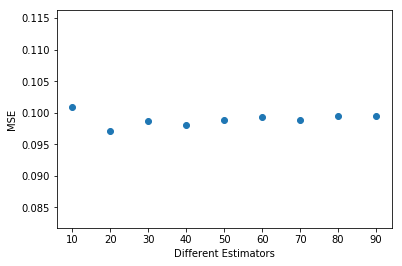

In [13]:
#Plotting the error graph
dumm_points = [i for i in range(1,10)]
plt.scatter(dumm_points,MSE)
plt.xlabel('Different Estimators')
plt.ylabel('MSE')
plt.xticks(range(1,10),grid_params_bow['n_estimators'])
plt.show()

### 2.Finding the accuracy on train and test data

In [14]:
#Finding the accuracy with test data
from sklearn.metrics import accuracy_score
bow_rf_model = grid_clf_bow.best_estimator_
bow_rf_labels_test = bow_rf_model.predict(bow_test_data)
bow_rf_test_score = accuracy_score(bow_rf_labels_test,balanced_test_score)*float(100)
print('The accuracy on test data is---> '+str(bow_rf_test_score))

The accuracy on test data is---> 90.01666666666667


In [15]:
#Finding the accuracy for train data
bow_rf_labels_train = bow_rf_model.predict(bow_train_data)
bow_rf_train_score = accuracy_score(bow_rf_labels_train,balanced_train_score)*float(100)
print('The accuracy on train data is---> '+str(bow_rf_train_score))

The accuracy on train data is---> 99.89285714285714


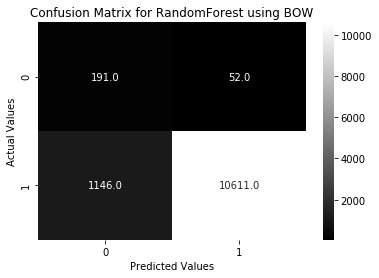

In [16]:
#Building the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
bow_rf_cnf = confusion_matrix(bow_rf_labels_test,balanced_test_score)
sns.heatmap(bow_rf_cnf,annot=True,fmt='.1f',cmap=plt.cm.gray)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix for RandomForest using BOW')
plt.show()

In [17]:
#Finding the tnr,fpr,fnr,tpr
tnr_rf_bow = bow_rf_cnf[0,0] 
fpr_rf_bow = bow_rf_cnf[0,1] 
fnr_rf_bow = bow_rf_cnf[1,0] 
tpr_rf_bow = bow_rf_cnf[1,1] 
print('The TNR for BOW is '+str(tnr_rf_bow))
print('The FPR for BOW is '+str(fpr_rf_bow))
print('The FNR for BOW is '+str(fnr_rf_bow))
print('The TPR for BOW is '+str(tpr_rf_bow))

The TNR for BOW is 191
The FPR for BOW is 52
The FNR for BOW is 1146
The TPR for BOW is 10611


In [18]:
#Finding the precision and recall
precision_rf_bow = tpr_rf_bow/(tpr_rf_bow+fpr_rf_bow)
recall_rf_bow = tpr_rf_bow/(tpr_rf_bow+fnr_rf_bow)
print('The precision for BOW is '+str(precision_rf_bow))
print('The recall for BOW is '+str(recall_rf_bow))

The precision for BOW is 0.9951233236425021
The recall for BOW is 0.9025261546312835


In [19]:
#Finding the F1 Score
f1_score_rf_bow = 2*(precision_rf_bow*recall_rf_bow)/(precision_rf_bow+recall_rf_bow)
print('The F1 Score for BOW is '+str(f1_score_rf_bow))

The F1 Score for BOW is 0.9465655664585192


## *Gradient Boosted Decision Trees

### 1.Applying GridSearchCV to find correct n_estimators for GBDT

In [20]:
grid_params_bow_gbdt = {'n_estimators':[i for i in range(100,210) if i%10==0]}
grid_estimator_bow_gbdt = xgb.XGBClassifier()
grid_clf_bow_gbdt = GridSearchCV(grid_estimator_bow_gbdt,grid_params_bow_gbdt)

In [21]:
grid_clf_bow_gbdt.fit(bow_train_data,balanced_train_score)

F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.si

F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.si

F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [22]:
grid_clf_bow_gbdt.best_params_

{'n_estimators': 200}

In [23]:
mean_test_scores = grid_clf_bow_gbdt.cv_results_['mean_test_score']
MSE = 1-mean_test_scores
MSE

array([0.09821429, 0.09721429, 0.09646429, 0.09575   , 0.09507143,
       0.09425   , 0.09392857, 0.09360714, 0.09271429, 0.09239286,
       0.09157143])

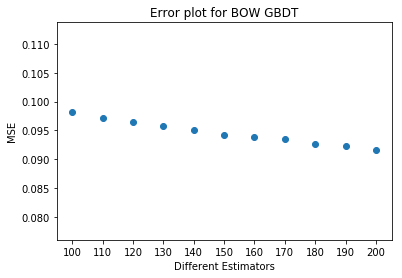

In [24]:
#Plotting the error graph
dumm_points = [i for i in range(1,12)]
plt.scatter(dumm_points,MSE)
plt.xlabel('Different Estimators')
plt.ylabel('MSE')
plt.xticks(range(1,12),grid_params_bow_gbdt['n_estimators'])
plt.title('Error plot for BOW GBDT')
plt.show()

### 2.Finding the accuracy on train and test data

In [25]:
#Finding accuracy on test data
bow_gbdt_model = grid_clf_bow_gbdt.best_estimator_
bow_gbdt_test_label = bow_gbdt_model.predict(bow_test_data)
bow_gbdt_test_score = accuracy_score(bow_gbdt_test_label,balanced_test_score)*float(100)
print("The accuracy score for test data is---> "+str(bow_gbdt_test_score))

The accuracy score for test data is---> 90.64999999999999


F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [26]:
#Finding accuracy on train data
bow_gbdt_train_label = bow_gbdt_model.predict(bow_train_data)
bow_gbdt_train_score = accuracy_score(bow_gbdt_train_label,balanced_train_score)*float(100)
print("The accuracy score for train data is ---> "+str(bow_gbdt_train_score))

The accuracy score for train data is ---> 91.63571428571429


F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


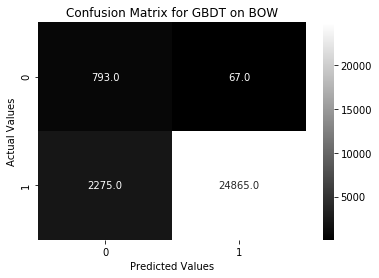

In [29]:
#Building the confusion matrix
bow_gbdt_cnf = confusion_matrix(bow_gbdt_train_label,balanced_train_score)
sns.heatmap(bow_gbdt_cnf,annot=True,fmt='.1f',cmap=plt.cm.gray)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix for GBDT on BOW')
plt.show()

In [30]:
#Finding the tnr,fpr,fnr,tpr
tnr_gbdt_bow = bow_gbdt_cnf[0,0] 
fpr_gbdt_bow = bow_gbdt_cnf[0,1] 
fnr_gbdt_bow = bow_gbdt_cnf[1,0] 
tpr_gbdt_bow = bow_gbdt_cnf[1,1] 
print('The TNR for BOW is '+str(tnr_gbdt_bow))
print('The FPR for BOW is '+str(fpr_gbdt_bow))
print('The FNR for BOW is '+str(fnr_gbdt_bow))
print('The TPR for BOW is '+str(tpr_gbdt_bow))

The TNR for BOW is 793
The FPR for BOW is 67
The FNR for BOW is 2275
The TPR for BOW is 24865


In [31]:
precision_gbdt_bow = tpr_gbdt_bow/(tpr_gbdt_bow+fpr_gbdt_bow)
recall_gbdt_bow = tpr_gbdt_bow/(tpr_gbdt_bow+fnr_gbdt_bow)
print('The precision for BOW GBDT is '+str(precision_gbdt_bow))
print('The recall for BOW GBDT is '+str(recall_gbdt_bow))

The precision for BOW GBDT is 0.9973126905182095
The recall for BOW GBDT is 0.9161753868828297


In [32]:
#Finding the F1 Score
f1_score_gbdt_bow = 2*(precision_gbdt_bow*recall_gbdt_bow)/(precision_gbdt_bow+recall_gbdt_bow)
print('The F1 Score for GBDT Bow is '+str(f1_score_gbdt_bow))

The F1 Score for GBDT Bow is 0.9550238131817483


# TFIDF Vectroizer

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_model = TfidfVectorizer()
tfidf_train_data = tfidf_model.fit_transform(balanced_train_data.CleanedText.values)
tfidf_train_data.shape

(28000, 21028)

In [34]:
tfidf_test_data = tfidf_model.transform(balanced_test_data.CleanedText.values)
tfidf_test_data.shape

(12000, 21028)

## *RandomForest 

### 1. Applying GridSearchCV to find optimal n_estimators for RandomForests

In [35]:
grid_params_rf_tf = {'n_estimators':[i for i in range(10,110) if i%10==0]}
grid_estimator_rf_tf = RandomForestClassifier()
grid_clf_rf_tf = GridSearchCV(grid_estimator_rf_tf,grid_params_rf_tf,scoring='accuracy')

In [36]:
grid_clf_rf_tf.fit(tfidf_train_data,balanced_train_score)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [37]:
grid_clf_rf_tf.best_params_

{'n_estimators': 20}

In [38]:
mean_test_scores = grid_clf_rf_tf.cv_results_['mean_test_score']
MSE = 1-mean_test_scores
MSE

array([0.09892857, 0.09885714, 0.09996429, 0.10035714, 0.10007143,
       0.10153571, 0.10060714, 0.10146429, 0.10096429, 0.10139286])

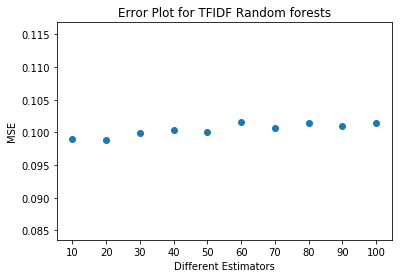

In [39]:
#Plotting the error graph
dumm_points = [i for i in range(1,11)]
plt.scatter(dumm_points,MSE)
plt.xlabel('Different Estimators')
plt.ylabel('MSE')
plt.title('Error Plot for TFIDF Random forests')
plt.xticks(range(1,11),grid_params_rf_tf['n_estimators'])
plt.show()

### 2.Finding the accuracy for train and test data

In [40]:
#Finding accuracy on test data
tf_rf_model = grid_clf_rf_tf.best_estimator_
tf_rf_test_labels = tf_rf_model.predict(tfidf_test_data)
tf_rf_test_score = accuracy_score(tf_rf_test_labels,balanced_test_score)*float(100)
print('The accuracy on test data is---> '+str(tf_rf_test_score))

The accuracy on test data is---> 89.86666666666666


In [41]:
#Finding accuracy on train data
tf_rf_train_labels = tf_rf_model.predict(tfidf_train_data)
tf_rf_train_score = accuracy_score(tf_rf_train_labels,balanced_train_score)*float(100)
print('The accuracy on train data is---> '+str(tf_rf_train_score))

The accuracy on train data is---> 99.825


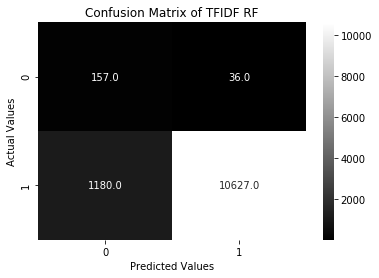

In [42]:
#Building the confusion matrix
tf_rf_cnf = confusion_matrix(tf_rf_test_labels,balanced_test_score)
sns.heatmap(tf_rf_cnf,annot=True,fmt='.1f',cmap=plt.cm.gray)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix of TFIDF RF')
plt.show()

In [43]:
#Finding the tnr,fpr,fnr,tpr
tnr_rf_tf = tf_rf_cnf[0,0] 
fpr_rf_tf = tf_rf_cnf[0,1] 
fnr_rf_tf = tf_rf_cnf[1,0] 
tpr_rf_tf = tf_rf_cnf[1,1] 
print('The TNR for TFIDF is '+str(tnr_rf_tf))
print('The FPR for TFIDF is '+str(fpr_rf_tf))
print('The FNR for TFIDF is '+str(fnr_rf_tf))
print('The TPR for TFIDF is '+str(tpr_rf_tf))

The TNR for TFIDF is 157
The FPR for TFIDF is 36
The FNR for TFIDF is 1180
The TPR for TFIDF is 10627


In [44]:
#Finding the precision and recall
precision_rf_tf = tpr_rf_tf/(tpr_rf_tf+fpr_rf_tf)
recall_rf_tf = tpr_rf_tf/(tpr_rf_tf+fnr_rf_tf)
print('The precision for TFIDF is '+str(precision_rf_tf))
print('The recall for TFIDF is '+str(recall_rf_tf))

The precision for TFIDF is 0.9966238394448091
The recall for TFIDF is 0.9000592868637249


In [45]:
#Finding the F1 Score
f1_score_rf_tf = 2*(precision_rf_tf*recall_rf_tf)/(precision_rf_tf+recall_rf_tf)
print('The F1 Score for TFIDF is '+str(f1_score_rf_tf))

The F1 Score for TFIDF is 0.9458834000890075


## *Gradient Boosted Decision Trees

### 1.Applying GridSearchCV to find correct n_estimators for GBDT

In [46]:
grid_params_gbdt_tf = {'n_estimators':[i for i in range(100,210) if i%10==0]}
grid_estimator_gbdt_tf = xgb.XGBClassifier()
grid_clf_gbdt_tf = GridSearchCV(grid_estimator_gbdt_tf,grid_params_gbdt_tf)

In [47]:
grid_clf_gbdt_tf.fit(tfidf_train_data,balanced_train_score)

F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.si

F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.si

F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [48]:
grid_clf_gbdt_tf.best_params_

{'n_estimators': 200}

In [49]:
mean_test_scores =  grid_clf_gbdt_tf.cv_results_['mean_test_score']
MSE = 1-mean_test_scores
MSE

array([0.09832143, 0.09685714, 0.09589286, 0.09514286, 0.09446429,
       0.094     , 0.09317857, 0.09235714, 0.09228571, 0.09139286,
       0.09089286])

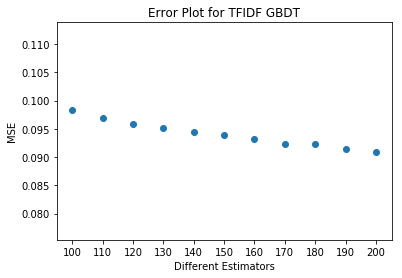

In [50]:
#Plotting the error graph
dumm_points = [i for i in range(1,12)]
plt.scatter(dumm_points,MSE)
plt.xlabel('Different Estimators')
plt.ylabel('MSE')
plt.title('Error Plot for TFIDF GBDT')
plt.xticks(range(1,12),grid_params_gbdt_tf['n_estimators'])
plt.show()

### 2.Finding the accuracy on train and test data

In [51]:
#Finding the accuracy for test data
tf_gbdt_model = grid_clf_gbdt_tf.best_estimator_
tf_gbdt_test_labels = tf_gbdt_model.predict(tfidf_test_data)
tf_gbdt_test_score = accuracy_score(tf_gbdt_test_labels,balanced_test_score)*float(100)
print('The accuracy on test data is---> '+str(tf_gbdt_test_score))

The accuracy on test data is---> 90.75


F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [52]:
#Finding the accuracy on train data
tf_gbdt_train_labels = tf_gbdt_model.predict(tfidf_train_data)
tf_gbdt_train_score = accuracy_score(tf_gbdt_train_labels,balanced_train_score)*float(100)
print('The accuracy on train data is---> '+str(tf_gbdt_train_score))

The accuracy on train data is---> 91.90357142857142


F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


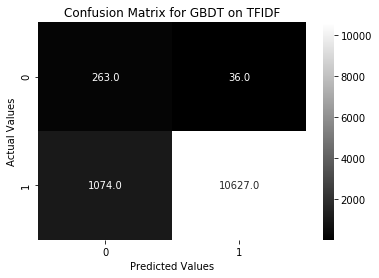

In [53]:
#Building the confusion matrix
tf_gbdt_cnf = confusion_matrix(tf_gbdt_test_labels,balanced_test_score)
sns.heatmap(tf_gbdt_cnf,annot=True,fmt='.1f',cmap=plt.cm.gray)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix for GBDT on TFIDF')
plt.show()

In [54]:
#Finding the tnr,fpr,fnr,tpr
tnr_gbdt_tf = tf_gbdt_cnf[0,0] 
fpr_gbdt_tf = tf_gbdt_cnf[0,1] 
fnr_gbdt_tf = tf_gbdt_cnf[1,0] 
tpr_gbdt_tf = tf_gbdt_cnf[1,1] 
print('The TNR for TFIDF is '+str(tnr_gbdt_tf))
print('The FPR for TFIDF is '+str(fpr_gbdt_tf))
print('The FNR for TFIDF is '+str(fnr_gbdt_tf))
print('The TPR for TFIDF is '+str(tpr_gbdt_tf))

The TNR for TFIDF is 263
The FPR for TFIDF is 36
The FNR for TFIDF is 1074
The TPR for TFIDF is 10627


In [55]:
precision_gbdt_tf = tpr_gbdt_tf/(tpr_gbdt_tf+fpr_gbdt_tf)
recall_gbdt_tf = tpr_gbdt_tf/(tpr_gbdt_tf+fnr_gbdt_tf)
print('The precision for TFIDF GBDT is '+str(precision_gbdt_tf))
print('The recall for TFIDF GBDT is '+str(recall_gbdt_tf))

The precision for TFIDF GBDT is 0.9966238394448091
The recall for TFIDF GBDT is 0.9082129732501496


In [56]:
#Finding the F1 Score
f1_score_gbdt_tf = 2*(precision_gbdt_tf*recall_gbdt_tf)/(precision_gbdt_tf+recall_gbdt_tf)
print('The recall for TFIDF GBDT is '+str(f1_score_gbdt_tf))

The recall for TFIDF GBDT is 0.9503666607047039


# Word2Vec

In [57]:
import re
#Removing Html tags
def cleanHtml(sentence):
    cleanText = re.sub('<.*?>','',sentence)
    return cleanText
#Removing Punctuations
def cleanPunc(word):
    cleaned = re.sub(r'[#|!|?|\'|@|"]','',word)
    cleaned = re.sub(r'[,|.|(|)|\|/]',' ',word)
    return cleaned

In [58]:
train_test_data = balanced_sorted_data.iloc[:40000]

In [59]:
#Filtering the sentences for using in word2vec
from gensim.models import Word2Vec
final_sentences = []
for sentence in train_test_data.Text.values:    
    sent = cleanHtml(sentence)       #Cleaning the html tags from the sentences
    filtered_sentence = []           #The filtered sentences to be stored in this list
    for word in sent.split():    #Looping through each word
        for cleaned_word in cleanPunc(word).split():   #Cleaning the punctuations from each word
            if(cleaned_word.isalpha()):              
                filtered_sentence.append(cleaned_word.lower())   #Converting the cleaned word to lowercase
            else:
                continue
    final_sentences.append(filtered_sentence)      #Inserting each filtered sentence to the final list

F:\Anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [60]:
len(final_sentences)

40000

In [61]:
#Training the Word2Vec model
train_sentences = final_sentences[:28000]
w2v_model = Word2Vec(train_sentences,size=50,workers=4)

In [62]:
words = set(w2v_model.wv.vocab)
len(words)

10000

# Average Word2Vec

In [63]:
#Building model for average word2vec
sent_vectors = []
for sentence in final_sentences:    
    sentence_vectors = np.zeros(50)    #Building word vectors and initializing with 0
    count = 0   #Counting the total number of words in the sentence
    for word in sentence:
        try:
            count+=1           
            w2v = w2v_model.wv[word]    #Appling word2vec for each word
            sentence_vectors+=w2v        #Adding word2vec of each word to sentence vectors
        except:
            pass
    sentence_vectors/=count            #Computing average word2vec
    sent_vectors.append(sentence_vectors)

In [64]:
sent_vectors_df = pd.DataFrame(sent_vectors)
sent_vectors_df.shape

(40000, 50)

In [65]:
#Building 70% and 30% train and test data
avgw2v_train_data = sent_vectors_df.iloc[:28000]
avgw2v_test_data = sent_vectors_df.iloc[28000:40000]
print(avgw2v_train_data.shape)
avgw2v_test_data.shape

(28000, 50)


(12000, 50)

## *RandomForests

### 1. Applying GridSearchCV to find optimal n_estimators for RandomForests

In [66]:
grid_params_tf_av = {'n_estimators':[i for i in range(10,110) if i%10==0]}
grid_estimator_tf_av = RandomForestClassifier()
grid_clf_tf_av = GridSearchCV(grid_estimator_tf_av,grid_params_tf_av,scoring='accuracy')

In [67]:
grid_clf_tf_av.fit(avgw2v_train_data,balanced_train_score)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [68]:
grid_clf_tf_av.best_params_

{'n_estimators': 50}

In [69]:
mean_test_scores = grid_clf_tf_av.cv_results_['mean_test_score']
MSE = 1-mean_test_scores
MSE

array([0.10803571, 0.10507143, 0.10428571, 0.10535714, 0.10417857,
       0.10471429, 0.10496429, 0.10442857, 0.10460714, 0.10503571])

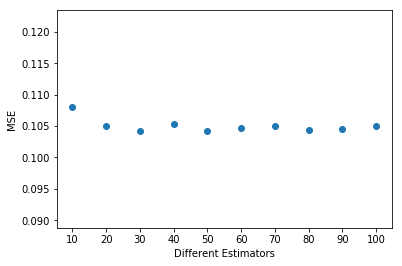

In [70]:
#Plotting the error graph
dumm_points = [i for i in range(1,11)]
plt.scatter(dumm_points,MSE)
plt.xlabel('Different Estimators')
plt.ylabel('MSE')
plt.xticks(range(1,11),grid_params_tf_av['n_estimators'])
plt.show()

### 2.Finding the accuracy on train and test data


In [71]:
#Finding accuracy on test data
av_rf_model = grid_clf_tf_av.best_estimator_
av_rf_test_labels = av_rf_model.predict(avgw2v_test_data)
av_rf_test_score = accuracy_score(av_rf_test_labels,balanced_test_score)*float(100)
print('The accuracy on test data is---> '+str(av_rf_test_score))

The accuracy on test data is---> 89.14999999999999


In [72]:
#Finding accuracy on train data
av_rf_train_labels = av_rf_model.predict(avgw2v_train_data)
av_rf_train_score = accuracy_score(av_rf_train_labels,balanced_train_score)*float(100)
print('The accuracy on train data is---> '+str(av_rf_train_score))

The accuracy on train data is---> 99.97142857142856


## *Gradient Boosted Decision Trees

### 1. Applying GridSearchCV to find optimal n_estimators for GBDT

In [73]:
grid_params_gbdt_av = {'n_estimators':[i for i in range(100,210) if i%10==0]}
grid_estimator_gbdt_av = xgb.XGBClassifier()
grid_clf_gbdt_av = GridSearchCV(grid_estimator_gbdt_av,grid_params_gbdt_av,scoring='accuracy')

In [74]:
grid_clf_gbdt_av.fit(avgw2v_train_data,balanced_train_score)

F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.si

F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.si

F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [75]:
grid_clf_gbdt_av.best_params_

{'n_estimators': 200}

In [76]:
mean_test_scores = grid_clf_gbdt_av.cv_results_['mean_test_score']
MSE = 1-mean_test_scores
MSE

array([0.10135714, 0.10092857, 0.09985714, 0.09978571, 0.09917857,
       0.09889286, 0.09864286, 0.09821429, 0.09810714, 0.09771429,
       0.09753571])

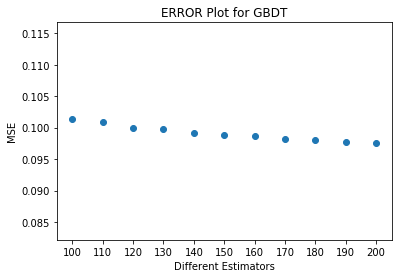

In [77]:
#Plotting the error graph
dumm_points = [i for i in range(1,12)]
plt.scatter(dumm_points,MSE)
plt.xlabel('Different Estimators')
plt.ylabel('MSE')
plt.title('ERROR Plot for GBDT')
plt.xticks(range(1,12),grid_params_gbdt_av['n_estimators'])
plt.show()

### 2.Finding train and test accuracy

In [78]:
#Finding test accuracy
gbdt_av_model = grid_clf_gbdt_av.best_estimator_
gbdt_av_test_labels = gbdt_av_model.predict(avgw2v_test_data)
gbdt_av_test_score = accuracy_score(gbdt_av_test_labels,balanced_test_score)*float(100)
print('The accuracy score for test data is---> '+str(gbdt_av_test_score))

The accuracy score for test data is---> 89.83333333333333


F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [79]:
#Finding train accuracy
gbdt_av_train_labels = gbdt_av_model.predict(avgw2v_train_data)
gbdt_av_train_score = accuracy_score(gbdt_av_train_labels,balanced_train_score)*float(100)
print('The accuracy score for train data is---> '+str(gbdt_av_train_score))

The accuracy score for train data is---> 91.55714285714286


F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# TFIDF Weighted Word2Vec

In [80]:
#Taking 10k data points
train_data = balanced_sorted_data.iloc[:7000]
train_test_data = balanced_sorted_data.iloc[:10000]
fin_sentences = final_sentences[:10000]

In [81]:
train_data_score = balanced_train_score[:7000]
test_data_score = balanced_test_score[7000:10000]

In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_model = TfidfVectorizer()
tf_idf_model.fit(train_data.Text.values)
tf_idf_model_final = tf_idf_model.transform(train_test_data.Text.values)
tf_idf_model_final.shape

(10000, 19568)

In [83]:
#Building the Weighted TFIDF W2V
tf_features = tf_idf_model.get_feature_names()    #Retrieving the tfidf feature names
weighted_sentences = [];
row = 0;
for sentence in fin_sentences:
    sum_vector = np.zeros(50)     #Building word vectors and initializing with 0
    weighted_sum = 0;             #Initializing the weighted sum to 0
    for word in sentence:         #Looping through each word
        try: 
            w2v = w2v_model.wv[word]         #Applying the word2vec model on each word
            tf_idf = tf_idf_model_final[row,tf_features.index(word)]      #Retrieving the tfidf value for the corresponding word
            sum_vector += (w2v*tf_idf)          #Computing tfidf weighted w2v
            weighted_sum += tf_idf              #Computing the total tfidf weight
        except:
            pass
    sum_vector/=weighted_sum              #Final tfidf weighted w2v
    weighted_sentences.append(sum_vector)
    row += 1 

In [84]:
#Converting the weighted sentences list to a DataFrame
weighted_df = pd.DataFrame(weighted_sentences) 
weighted_df.shape

(10000, 50)

In [85]:
#Building 70% and 30% train-test data set
tfidfw2v_train_data = weighted_df.iloc[0:7000,:]
tfidfw2v_test_data = weighted_df.iloc[7000:10000]
print(tfidfw2v_train_data.shape)
tfidfw2v_test_data.shape

(7000, 50)


(3000, 50)

## *RandomForests

### 1. Applying GridSearchCV to find optimal n_estimators for RandomForests

In [86]:
grid_params_rf_tw = {'n_estimators':[i for i in range(10,110) if i%10==0]}
grid_estimator_rf_tw = RandomForestClassifier()
grid_clf_rf_tw = GridSearchCV(grid_estimator_rf_tw,grid_params_rf_tw,scoring='accuracy')

In [88]:
grid_clf_rf_tw.fit(tfidfw2v_train_data,train_data_score)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [90]:
grid_clf_rf_tw.best_params_

{'n_estimators': 80}

In [91]:
mean_test_scores = grid_clf_rf_tw.cv_results_['mean_test_score']
MSE = 1-mean_test_scores
MSE

array([0.12457143, 0.11528571, 0.11528571, 0.11328571, 0.11342857,
       0.113     , 0.113     , 0.11242857, 0.114     , 0.11271429])

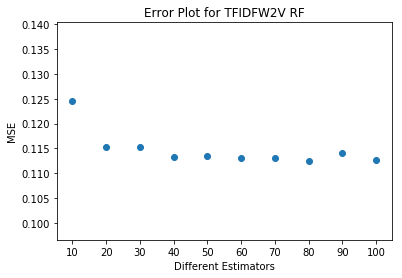

In [92]:
#Plotting the error graph
dumm_points = [i for i in range(1,11)]
plt.scatter(dumm_points,MSE)
plt.xlabel('Different Estimators')
plt.ylabel('MSE')
plt.title('Error Plot for TFIDFW2V RF')
plt.xticks(range(1,11),grid_params_rf_tw['n_estimators'])
plt.show()

### 2. Finding the train and test accuracy

In [93]:
#Finding the accuracy for test data
rf_tw_model = grid_clf_rf_tw.best_estimator_
rf_tw_test_labels = rf_tw_model.predict(tfidfw2v_test_data)
rf_tw_test_score = accuracy_score(rf_tw_test_labels,test_data_score)*float(100)
print('The accuracy with test data is---> '+str(rf_tw_test_score))

The accuracy with test data is---> 87.46666666666667


In [94]:
#Finding the accuracy with train data
rf_tw_train_labels = rf_tw_model.predict(tfidfw2v_train_data)
rf_tw_train_score = accuracy_score(rf_tw_train_labels,train_data_score)*float(100)
print('The accuracy with train data is---> '+str(rf_tw_train_score))

The accuracy with train data is---> 100.0


## *Gradient Boosted Decision Trees

### 1. Applying GridSearchCV to find optimal n_estimators for GBDT

In [95]:
grid_params_gbdt_tw = {'n_estimators':[i for i in range(100,210) if i%10==0]}
grid_estimator_gbdt_tw = xgb.XGBClassifier()
grid_clf_gbdt_tw = GridSearchCV(grid_estimator_gbdt_tw,grid_params_gbdt_tw,scoring='accuracy')

In [96]:
grid_clf_gbdt_tw.fit(tfidfw2v_train_data,train_data_score)

F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.si

F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.si

F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [97]:
grid_clf_gbdt_tw.best_params_

{'n_estimators': 190}

In [98]:
mean_test_scores = grid_clf_gbdt_tw.cv_results_['mean_test_score']
MSE = 1-mean_test_scores
MSE

array([0.10914286, 0.10985714, 0.10985714, 0.11014286, 0.10914286,
       0.10885714, 0.10857143, 0.10857143, 0.10828571, 0.10757143,
       0.10828571])

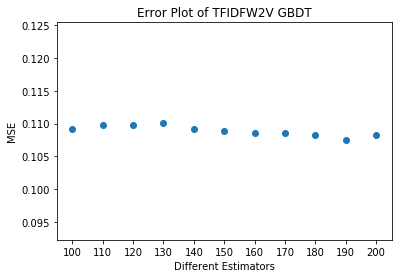

In [99]:
#Plotting the error graph
dumm_points = [i for i in range(1,12)]
plt.scatter(dumm_points,MSE)
plt.xlabel('Different Estimators')
plt.ylabel('MSE')
plt.title('Error Plot of TFIDFW2V GBDT')
plt.xticks(range(1,12),grid_params_gbdt_tw['n_estimators'])
plt.show()

### 2. Finding train and test accuracy

In [100]:
#Finding the test accuracy
gbdt_tw_model = grid_clf_gbdt_tw.best_estimator_
gbdt_tw_test_labels = gbdt_tw_model.predict(tfidfw2v_test_data)
gbdt_tw_test_score = accuracy_score(gbdt_tw_test_labels,test_data_score)*float(100)
print('The accuracy score for test data is ---> '+str(gbdt_tw_test_score))

The accuracy score for test data is ---> 85.39999999999999


F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [101]:
#Finding the train accuracy
gbdt_tw_train_labels = gbdt_tw_model.predict(tfidfw2v_train_data)
gbdt_tw_train_score = accuracy_score(gbdt_tw_train_labels,train_data_score)*float(100)
print('The accuracy score for train data is---> '+str(gbdt_tw_train_score))

The accuracy score for train data is---> 93.22857142857143


F:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# Summary for RandomForestClassifier

In [102]:
summ_rf = {'Models':['Bag Of Words','TFIDF Vectorizer','Average Word2Vec','TFIDF Word2Vec'],'n_estimators':[str(grid_clf_bow.best_params_),str(grid_clf_rf_tf.best_params_),str(grid_clf_tf_av.best_params_),str(grid_clf_rf_tw.best_params_)],'Test Accuracy':[str(bow_rf_test_score),str(tf_rf_test_score),str(av_rf_test_score),str(rf_tw_test_score)],'Train Accuracy':[str(bow_rf_train_score),str(tf_rf_train_score),str(av_rf_train_score),str(rf_tw_train_score)]}
summ_rf_df = pd.DataFrame(summ_rf)
summ_rf_df

,Models,n_estimators,Test Accuracy,Train Accuracy
0,Bag Of Words,{'n_estimators': 20},90.01666666666667,99.89285714285714
1,TFIDF Vectorizer,{'n_estimators': 20},89.86666666666666,99.825
2,Average Word2Vec,{'n_estimators': 50},89.14999999999999,99.97142857142856
3,TFIDF Word2Vec,{'n_estimators': 80},87.46666666666667,100.0


## Conclusion
### BOW Performed the best with Random Forest Classifier

# Summary for Gradient Boosted Decision Trees

In [103]:
summ_gbdt = {'Models':['Bag Of Words','TFIDF Vectorizer','Average Word2Vec','TFIDF Word2Vec'],'n_estimators':[str(grid_clf_bow_gbdt.best_params_),str(grid_clf_gbdt_tf.best_params_),str(grid_clf_gbdt_av.best_params_),str(grid_clf_gbdt_tw.best_params_)],'Test Accuracy':[str(bow_gbdt_test_score),str(tf_gbdt_test_score),str(gbdt_av_test_score),str(gbdt_tw_test_score)],'Train Accuracy':[str(bow_gbdt_train_score),str(tf_gbdt_train_score),str(gbdt_av_train_score),str(gbdt_tw_train_score)]}
summ_gbdt_df = pd.DataFrame(summ_gbdt)
summ_gbdt_df

,Models,n_estimators,Test Accuracy,Train Accuracy
0,Bag Of Words,{'n_estimators': 200},90.64999999999999,91.63571428571429
1,TFIDF Vectorizer,{'n_estimators': 200},90.75,91.90357142857142
2,Average Word2Vec,{'n_estimators': 200},89.83333333333333,91.55714285714286
3,TFIDF Word2Vec,{'n_estimators': 190},85.39999999999999,93.22857142857143


## Conclusion
### TFIDF Vectorizer Performed the best with GBDT